In [234]:
import env as env
from agent import agent
import utils
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Environment

In [235]:
environment = env.env()

Environment Ready.


In [236]:
environment.probability_matrix

array([[0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1.]])

In [237]:
environment.probability_matrix_df

0               1               2               3  ...         4        \
  left right stay left right stay left right stay left  ... stay left right   
0  0.0   0.0  1.0  1.0   0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0   0.0   
1  0.0   1.0  0.0  0.0   0.0  1.0  1.0   0.0  0.0  0.0  ...  0.0  0.0   0.0   
2  0.0   0.0  0.0  0.0   1.0  0.0  0.0   0.0  1.0  1.0  ...  0.0  0.0   0.0   
3  0.0   0.0  0.0  0.0   0.0  0.0  0.0   1.0  0.0  0.0  ...  1.0  1.0   0.0   
4  0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0   0.0   
5  0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0   1.0   
6  0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0   0.0   

          5               6             
  stay left right stay left right stay  
0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  
1  0.0  0.0   0.0  0.0  0.0   0.0  0.0  
2  0.0  0.0   0.0  0.0  0.0   0.0  0.0  
3  0.0  0.0   0.0  0.0  0.0   0.0  0.0  
4  1.0  1.0   0.0  0.0  0.0   0.0  0.0  
5  0.0  0.0   0.0  1.0  1.0   0.0  0.0  
6  0.0  0.0   1.0  0.0  0.0   0.0  1.0  

[7 rows x 21 columns]

In [238]:
left_columns = [col for col in environment.probability_matrix_df.columns if 'left' in col]
environment.probability_matrix_df[left_columns]

,0,1,2,3,4,5,6
,left,left,left,left,left,left,left
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [239]:
stay_columns = [col for col in environment.probability_matrix_df.columns if 'stay' in col]
environment.probability_matrix_df[stay_columns]

,0,1,2,3,4,5,6
,stay,stay,stay,stay,stay,stay,stay
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [240]:
environment.probability_matrix_df[0]

,left,right,stay
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
5,0.0,0.0,0.0
6,0.0,0.0,0.0


In [241]:
environment.rewards

array([[ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0., 10.,  0.],
       [ 0.,  0., 10.]])

In [242]:
environment.rewards_df 

,left,right,stay
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
5,0.0,10.0,0.0
6,0.0,0.0,10.0


## Policy

We define a random starting policy.

In [243]:
policy = {}
for state in environment.states:
    for action in state.actions:
        policy[(state.number, action.name)] = 1/len(state.actions)

In [245]:
agent = agent(policy)

In [246]:
agent.policy

{(0, 'right'): 0.5,
 (0, 'stay'): 0.5,
 (1, 'left'): 0.3333333333333333,
 (1, 'right'): 0.3333333333333333,
 (1, 'stay'): 0.3333333333333333,
 (2, 'left'): 0.3333333333333333,
 (2, 'right'): 0.3333333333333333,
 (2, 'stay'): 0.3333333333333333,
 (3, 'left'): 0.3333333333333333,
 (3, 'right'): 0.3333333333333333,
 (3, 'stay'): 0.3333333333333333,
 (4, 'left'): 0.3333333333333333,
 (4, 'right'): 0.3333333333333333,
 (4, 'stay'): 0.3333333333333333,
 (5, 'left'): 0.3333333333333333,
 (5, 'right'): 0.3333333333333333,
 (5, 'stay'): 0.3333333333333333,
 (6, 'left'): 0.5,
 (6, 'stay'): 0.5}

### MDP + Policy

Power Iteration

$V_k(s) = (R^\pi + \gamma P^\pi) V_{k-1}$

where 

$ R^\pi(s) = \sum_{a \in A} \pi (a \lvert s)R(s,a)$


and

$ P^\pi(s' \lvert s) = \sum_{a \in A} \pi(a \lvert s)P(s' \lvert s,a) $

In [255]:
r_pi = [0 for i in range(len(environment.states))]

for state in environment.states:
    r_pi[state.number] = 0
    for action in state.actions:
        r_pi[state.number] += agent.policy[(state.number, action.name)] * environment.rewards_df.loc[state.number, action.name]

In [256]:
r_pi

[0.5, 0.3333333333333333, 0.0, 0.0, 0.0, 3.333333333333333, 5.0]

$ P^\pi(s' \lvert s) = \sum_{a \in A} \pi(a \lvert s)P(s' \lvert s,a) $

In [257]:
p_pi = np.zeros( ( len(environment.states), len(environment.states) ) )

for state in environment.states:
    for state2 in environment.states:
        p_pi[state.number, state2.number] = 0

for state in environment.states:
    for action in state.actions:
        for state_key,state_value in action.function(state).items():
            p_pi[state_key.number, state.number] += agent.policy[(state.number, action.name)] * state_value

In [258]:
p_pi

array([[0.5       , 0.33333333, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.5       , 0.33333333, 0.33333333, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.33333333, 0.33333333, 0.33333333, 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.33333333, 0.33333333,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.33333333, 0.33333333,
        0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.33333333,
        0.33333333, 0.5       ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.33333333, 0.5       ]])

Computation


$V_k(s) = (R^\pi + \gamma P^\pi) V_{k-1}$


In [259]:
epsilon = 0.0001

In [260]:
v_pi = {}
r = environment.rewards
v_pi[0] = [0] * len(r)

r = r_pi
p = p_pi
gamma = environment.DISCOUNT_FACTOR

v_pi[0]

[0, 0, 0, 0, 0, 0, 0]

In [261]:
p

array([[0.5       , 0.33333333, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.5       , 0.33333333, 0.33333333, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.33333333, 0.33333333, 0.33333333, 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.33333333, 0.33333333,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.33333333, 0.33333333,
        0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.33333333,
        0.33333333, 0.5       ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.33333333, 0.5       ]])

In [262]:
v_pi[1] = (r + gamma * p @ v_pi[0])
v_pi[1]

i = 1
while np.max(np.abs(v_pi[i] - v_pi[i-1])) > epsilon:
    v_pi[i+1] = (r + gamma * p @ v_pi[i])
    i += 1

In [263]:
v_pi[i]

array([0.8191104 , 0.68605042, 0.201675  , 0.32243157, 1.41061469,
       6.73079922, 8.16237229])

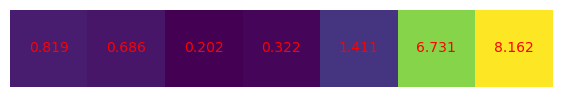

In [264]:
utils.plot_heatmap(v_pi[i])